# Subpockets to target residue(s)

We explore the distance of the `kissim` subpocket centers to their target residues.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from opencadd.databases.klifs import setup_remote

from kissim.encoding import FingerprintGenerator

In [3]:
plt.style.use("seaborn")

In [4]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../data/"
RESULTS = HERE / "../../results/"

In [5]:
REMOTE = setup_remote()

## Load subpocket center coordinates

In [6]:
fingerprint_generator = FingerprintGenerator.from_json(RESULTS / "fingerprints_clean.json")
print(f"Number of fingerprints: {len(fingerprint_generator.data)}")
# NBVAL_CHECK_OUTPUT

Number of fingerprints: 5222


In [7]:
subpocket_centers = fingerprint_generator.subpocket_centers
subpocket_centers = subpocket_centers.stack(0)
subpocket_centers.index.names = ("structure.klifs_id", "subpocket")
subpocket_centers = subpocket_centers.reset_index()
subpocket_centers["residue.ix"] = 0
subpocket_centers

dimension,structure.klifs_id,subpocket,x,y,z,residue.ix
0,3833,center,1.026647,20.789919,36.403976,0
1,3833,dfg_region,7.410334,20.057335,33.521000,0
2,3833,front_pocket,-0.280667,16.149000,39.317001,0
3,3833,hinge_region,1.976333,21.758667,41.804668,0
4,6679,center,1.047812,21.004131,36.159405,0
...,...,...,...,...,...,...
20795,7218,hinge_region,2.058333,22.553665,42.360996,0
20796,7219,center,0.650437,21.145950,37.116161,0
20797,7219,dfg_region,8.445666,22.603998,34.847000,0
20798,7219,front_pocket,0.248667,16.351334,39.368999,0


## Define target residues

In [8]:
subpocket_to_residue_ixs = {
    "hinge_region": [46, 47, 48],
    "dfg_region": [81, 82, 83],
    "front_pocket": [4, 5, 6, 7, 8, 9],
}
subpocket_to_residue_ixs

{'hinge_region': [46, 47, 48],
 'dfg_region': [81, 82, 83],
 'front_pocket': [4, 5, 6, 7, 8, 9]}

In [9]:
residue_ix_to_subpocket = {
    residue_ix: subpocket
    for subpocket, residue_ixs in subpocket_to_residue_ixs.items()
    for residue_ix in residue_ixs
}
residue_ix_to_subpocket

{46: 'hinge_region',
 47: 'hinge_region',
 48: 'hinge_region',
 81: 'dfg_region',
 82: 'dfg_region',
 83: 'dfg_region',
 4: 'front_pocket',
 5: 'front_pocket',
 6: 'front_pocket',
 7: 'front_pocket',
 8: 'front_pocket',
 9: 'front_pocket'}

## Load pocket residue CA atom coordinates

In [10]:
ca_atoms = pd.read_csv(
    DATA / "processed/pocket_residue_ca_atom_coordinates.csv.gz", header=0, index_col=[0, 1]
)
# Rename a few columns and reset index
ca_atoms = ca_atoms.rename(columns={"atom.x": "x", "atom.y": "y", "atom.z": "z"})
ca_atoms = ca_atoms.reset_index()
# Keep only target residues
ca_atoms = ca_atoms[ca_atoms["residue.ix"].isin(residue_ix_to_subpocket.keys())]
# Add subpocket name
ca_atoms["subpocket"] = ca_atoms.apply(lambda x: residue_ix_to_subpocket[x["residue.ix"]], axis=1)
# Keep only structures that we have subpocket centers for
ca_atoms = ca_atoms[
    ca_atoms["structure.klifs_id"].isin(subpocket_centers["structure.klifs_id"].unique())
]
ca_atoms

,structure.klifs_id,residue.ix,x,y,z,subpocket
3,3833,4,3.487,11.680,43.579,front_pocket
4,3833,5,6.188,10.086,41.434,front_pocket
5,3833,6,5.018,9.936,37.800,front_pocket
6,3833,7,6.529,10.561,34.362,front_pocket
7,3833,8,10.277,10.733,35.145,front_pocket
...,...,...,...,...,...,...
438581,7219,47,-0.478,23.541,46.525,hinge_region
438582,7219,48,-3.728,21.939,45.542,hinge_region
438615,7219,81,2.003,19.768,33.851,dfg_region
438616,7219,82,3.749,21.637,31.096,dfg_region


## Concatenate CA atom and subpocket center data

In [11]:
coordinates = (
    pd.concat([ca_atoms, subpocket_centers])
    .sort_values(["structure.klifs_id", "subpocket"])
    .reset_index(drop=True)
)
coordinates.index.name = "ix"
coordinates

,structure.klifs_id,residue.ix,x,y,z,subpocket
ix,,,,,,
0,1,0,0.783500,22.267733,37.174877,center
1,1,81,0.495000,19.480000,32.809000,dfg_region
2,1,82,3.266000,17.284000,34.243000,dfg_region
3,1,83,5.132000,16.924000,30.908000,dfg_region
4,1,0,7.576667,23.035334,34.537666,dfg_region
...,...,...,...,...,...,...
81155,13740,0,0.370667,16.046333,39.406334,front_pocket
81156,13740,46,0.505000,26.182000,43.555000,hinge_region
81157,13740,47,-0.600000,23.058000,45.492000,hinge_region


## Get vector between subpocket centers and their target residue CA atoms

In [12]:
vectors = coordinates.groupby(["structure.klifs_id", "subpocket"]).apply(
    lambda group: group[group["residue.ix"] != 0][["x", "y", "z"]]
    - group[group["residue.ix"] == 0][["x", "y", "z"]].squeeze()
)
vectors = (
    vectors.reset_index()
    .merge(coordinates.reset_index()[["ix", "residue.ix"]], how="left", on="ix")
    .set_index(["structure.klifs_id", "subpocket", "residue.ix"])
    .drop("ix", axis=1)
)
vectors

x         y         z
structure.klifs_id subpocket    residue.ix                               
1                  dfg_region   81          -7.081667 -3.555334 -1.728666
                                82          -4.310667 -5.751334 -0.294666
                                83          -2.444667 -6.111334 -3.629666
                   front_pocket 4            6.476667 -2.891666  4.076000
                                5            9.694667 -3.674666  2.196000
...                                               ...       ...       ...
13740              front_pocket 8           12.727333 -1.450333 -4.669334
                                9           12.419333 -1.222333 -0.907334
                   hinge_region 46          -1.476667  4.341668  1.819332
                                47          -2.581667  1.217668  3.756332
                                48          -5.906667 -0.609332  3.320332

[60360 rows x 3 columns]

## Get vector length (distance)

In [13]:
distances = vectors.apply(lambda x: np.linalg.norm(x), axis=1)
distances = distances.unstack(0).transpose()
distances

subpocket          dfg_region                     front_pocket             \
residue.ix                 81        82        83           4          5    
structure.klifs_id                                                          
1                    8.110407  7.193505  7.516600     8.180631  10.597743   
4                    6.898447  6.630098  5.231835     7.643434   9.226580   
8                    6.393397  8.394686  6.744004     7.559248   9.617310   
11                   7.237975  8.515901  6.093379     8.357121  10.724409   
15                   7.151968  8.723244  8.077608     9.000510   9.633533   
...                       ...       ...       ...          ...        ...   
13725                5.469200  5.961674  4.321307     7.290229   9.992944   
13726                5.434556  6.001615  4.392872     7.085804   9.752877   
13736                5.448673  6.028549  4.494076     7.244906  10.026624   
13738                5.505814  5.954355  4.205038     7.278635   9.932265   
13740                6.305268  6.283243  4.710864     6.561534   9.128367   

subpocket                                                      hinge_region  \
residue.ix                 6          7          8          9            46   
structure.klifs_id                                                            
1                         NaN  11.408242  13.840989  13.290591     4.977981   
4                    8.499980  11.159090  12.884741  12.570443     5.003263   
8                    9.839860        NaN        NaN  10.673312     5.121003   
11                  12.973671  14.884654  12.919863  12.291550     5.196987   
15                   7.539253   9.834125  11.270214  11.669971     4.710091   
...                       ...        ...        ...        ...          ...   
13725               10.911700  13.243892  11.031626  11.614490     5.223579   
13726               10.709254  13.478298  11.373215  11.522937     5.308616   
13736               10.865226  13.185148  11.032758  11.603389     5.249874   
13738               10.660118  12.969381  10.828608  11.617109     5.207077   
13740               10.388409  13.834132  13.634191  12.512282     4.933619   

subpocket                               
residue.ix                47        48  
structure.klifs_id                      
1                   4.987418  6.200912  
4                   5.070012  6.234286  
8                   5.351008  6.489459  
11                  5.194417  6.448320  
15                  5.085317  6.340704  
...                      ...       ...  
13725               5.105611  7.093942  
13726               5.169180  7.166404  
13736               5.129368  7.107697  
13738               5.104088  7.092584  
13740               4.717812  6.803279  

[5222 rows x 12 columns]

## Plot distance distributions

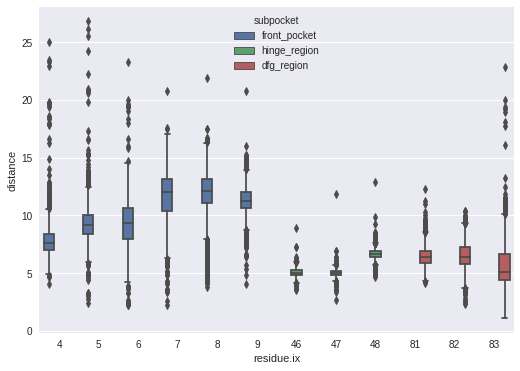

In [14]:
plt.figure(figsize=(8.5, 6))
ax = sns.boxplot(
    x="residue.ix",
    y="distance",
    hue="subpocket",
    data=distances.melt().sort_values("residue.ix").rename(columns={"value": "distance"}),
)

## Plot distance distributions split by DFG conformation

In [15]:
structures = REMOTE.structures.all_structures()

In [16]:
structure_klifs_ids_by_dfg = {
    name: group["structure.klifs_id"].to_list()
    for name, group in structures.groupby("structure.dfg")
}
distances_dict = {
    "All": distances,
    "DFG-in": distances[distances.index.isin(structure_klifs_ids_by_dfg["in"])],
    "DFG-out": distances[distances.index.isin(structure_klifs_ids_by_dfg["out"])],
}

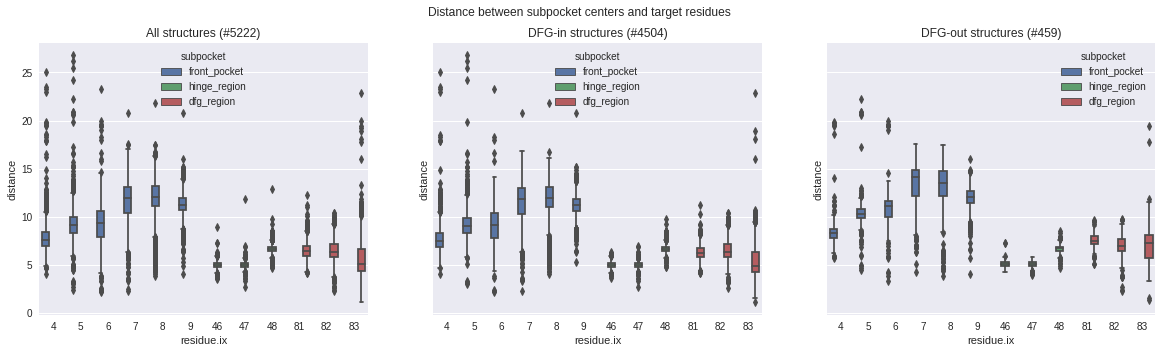

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
fig.suptitle("Distance between subpocket centers and target residues")
for i, (title, data) in enumerate(distances_dict.items()):
    sns.boxplot(
        x="residue.ix",
        y="distance",
        hue="subpocket",
        data=data.melt().sort_values("residue.ix").rename(columns={"value": "distance"}),
        ax=axes[i],
    )
    axes[i].set_title(f"{title} structures (#{len(data)})")